# Multi-task Learning
---

<font size="4"> 
  
  Multi-task learning is an approach for jointly training multiple models. It can be simply implemented in neural networks by learning tasks in parallel while using a shared representation.
  
The simplest way is when we have different outputs for the same input and simultaneously train a model to predict the two or more outputs. 
  
Parallel models can have both shared and independent layers.
  
  <figure>
<center>
<img src="https://drive.google.com/uc?id=1LdwHoHlwm2wQj6SHUazYkNcavTCJp1_X" width="400" height="300"/>
<figcaption>Multi-task learning</figcaption></center>
</figure>
  
In this excercise, we use the tags for chunking (which is provided in CONLL 2003 dataset in the third column) as our auxiliary outputs. The idea is that these two tasks can benefit from each other.
  
  
The sections of the code that should be modified for multi-tasking are as follows:
  


* Modify `readfile()`, to read the chunking column as well
* Create a dictionary that encode auxiliary tags
* Return auxiliary tags from class `CoNLL2003NER(Dataset)`
* Modify the model class. The architecture of the model will consist of one LSTM layer on top of embedding, then, two parallel LSTM layers, one to learn auxiliary tags and one to learn the main tags, and finally two Linear layers in similar fashion. The model returns two outputs accordingly.
* In the training loop, two losses will be computed, one for main tags predictions and one for auxiliary tags prediction. Backpropagation would be performed based on the addition of the two losses.
 
</font>

In [1]:
# The following two lines authorises access to Google Drive:
from google.colab import drive
drive.mount('/content/drive/')

import warnings
warnings.filterwarnings('ignore')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
import numpy as np
import time
import pdb
import torch
import gensim
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

use_cuda = torch.cuda.is_available()
print("cuda device {}available".format("" if use_cuda else "un"))
device = torch.device("cuda:0" if use_cuda else "cpu")

# Parameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 200
BATCH_SIZE = 256 #300
EPOCHS = 30
LSTM_DROPOUT = 0.3
USE_PRETRAINED = False

# data dir
data_folder = "/content/drive/My Drive/DLinNLP/Data"
# embeddings folder 
embed_folder = "/content/drive/My Drive/DLinNLP/embeddings"

cuda device available


## Data Format
---
<font size="4"> One standard file format for representing IOB-annotated datasets is called CONLL. 
  
A CONLL file contains one token per line and an empty line indicating the end of a sentence. Each token may be annotated by several tab-separated columns indicating information about the token (e.g. token raw form) or differrent tags assigned to it (e.g. syntactic and morphological labels).
</font>

<P>
<table align="left" style="width:100%">
  <tr>
    <td>Welsh</td>
    <td>NNP</td> 
    <td>B-NP</td>
    <td><b>B-ORG</td>
  </tr>
  <tr>
    <td>National</td>
    <td>NNP</td> 
    <td>I-NP</td>
    <td><b>I-ORG</td>
  </tr>
  <tr>
    <td>Farmers</td>
    <td>NNP</td> 
    <td>I-NP</td>
    <td><b>I-ORG</td>
  </tr>
  <tr>
    <td>'</td>
    <td>POS</td> 
    <td>B-NP</td>
    <td><b>I-ORG</td>
  </tr>
  <tr>
    <td>Union</td>
    <td>NNP</td> 
    <td>I-NP</td>
    <td><b>I-ORG</td>
  </tr>
  <tr>
    <td>(</td>
    <td>(</td> 
    <td>O</td>
    <td><b>O</td>
  </tr>
  <tr>
    <td>NFU</td>
    <td>NNP</td> 
    <td>B-NP</td>
    <td><b>B-ORG</td>
  </tr>
  <tr>
    <td>)</td>
    <td>)</td> 
    <td>O</td>
    <td><b>O</td>
  </tr>
  <tr>
    <td>chairman</td>
    <td>NN</td> 
    <td>B-NP</td>
    <td><b>O</td>
  </tr>
  <tr>
    <td>John</td>
    <td>NNP</td> 
    <td>I-NP</td>
    <td><b>B-PER</td>
  </tr>
  <tr>
    <td>Lloyd</td>
    <td>NNP</td> 
    <td>I-NP</td>
    <td><b>I-PER</td>
  </tr>
  <tr>
    <td>said</td>
    <td>VBD</td> 
    <td>B-VP</td>
    <td><b>O</td>
  </tr>
  <tr>
    <td>on</td>
    <td>IN</td> 
    <td>B-PP</td>
    <td><b>O</td>
  </tr>
  <tr>
    <td>BBC</td>
    <td>NNP</td> 
    <td>B-NP</td>
    <td><b>B-ORG</td>
  </tr>
  <tr>
    <td>radio</td>
    <td>NN</td> 
    <td>I-NP</td>
    <td><b>I-ORG</td>
  </tr>
  <tr>
    <td>.</td>
    <td>.</td> 
    <td>O</td>
    <td><b>O</b></td>
  </tr>
  <tr>
    <td><br></tr>
    <td><font size="4"> Here, we read the CONLL 2003 dataset! <font></td>
  </tr>
</table>

<br>
</P> 


In [3]:
#
# This fuction has been modified to read the chunking column as well.

def readfile(filename):
    f = open(filename)
    sentences = []
    sentence = []
    for line in f:
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
            if len(sentence) > 0:
                sentences.append(sentence)
                sentence = []
            continue
        splits = line.split(' ')
        sentence.append([splits[0].strip(), splits[-2].strip(), splits[-1].strip()])

    if len(sentence) > 0:
        sentences.append(sentence)
        sentence = []
    sentences = [tuple(zip(*l)) for l in sentences]
    return sentences

train_data = np.array(readfile(data_folder+'/train.txt'))
dev_data = np.array(readfile(data_folder+'/dev.txt'))
test_data = np.array(readfile(data_folder+'/test.txt'))

#train_data = train_data[0:6000,:]
print(train_data.shape)
print(train_data[0])
print(dev_data.shape)

(14041, 3)
[('EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.')
 ('B-NP', 'B-VP', 'B-NP', 'I-NP', 'B-VP', 'I-VP', 'B-NP', 'I-NP', 'O')
 ('B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O')]
(3250, 3)


## Pre-processing 
---

<font size="4">It is common to sort data instances based on their lengths. This way, the lengths of sequences in each batch would be more homogeneous. 
<font>

In [0]:
# This reordering is useful for padding
def tensor_reorder(data):
    """reorders tensors from longest to shortest"""
    lengths = [len(i[0]) for i in data]
    max_len = max(lengths)
    lengths = torch.LongTensor(lengths)
    lengths, perm_idx = lengths.sort(0, descending=True)
    data = data[perm_idx]
    return data

train_data = tensor_reorder(train_data)
dev_data = tensor_reorder(dev_data)

test_data = tensor_reorder(test_data)

MAX_LEN = max(len(train_data[0][0]), len(dev_data[0][0])) # we set the maximum length from the max seq in train 

In [0]:
# Here, we create a dictionary that maps all words to indices (for encoding)

all_words = list(set([w for sent in np.concatenate((train_data,dev_data), axis=0) for w in sent[0]]))

word_to_ix = {t:i+2 for i, t in enumerate(all_words)}
word_to_ix['<PAD>'] = 0
word_to_ix['<UNK>'] = 1


all_tags_aux = list(set([tag for sent in np.concatenate((train_data,dev_data), axis=0) for tag in sent[1]]))
tag_to_ix_aux = {t:i+1 for i, t in enumerate(all_tags_aux)}
tag_to_ix_aux['<PAD>'] = 0
ix_to_tag_aux = {v: k for k, v in tag_to_ix_aux.items()}

# The tagset is simplified (NE categories not included) 
tag_to_ix = {'<PAD>':0, 'B-MISC':1, 'B-LOC':1, 'B-ORG':1, 'B-PER':1,
             'I-MISC':2, 'I-PER':2, 'I-ORG':2, 'I-LOC':2, 'O':3}
ix_to_tag = {0:'<PAD>', 1:'B', 2:'I', 3:'O'}

## If we wanted to consider tags in their entirety:
# all_tags = list(set([tag for sent_tag in train_data for tag in sent_tag[1]]))
# tag_to_ix = {t:i+1 for i, t in enumerate(all_tags)}
# tag_to_ix['<PAD>'] = 0
# ix_to_tag = {v: k for k, v in tag_to_ix.items()}

In [0]:
# This class creates a generator of data batches in order to faster the access to data.
class CoNLL2003NER(Dataset):

    def __init__(self, X, max_len, word_to_ix, tag_to_ix_aux, tag_to_ix):
        self.X = X
        self.max_len = max_len
        self.word_to_ix = word_to_ix
        self.tag_to_ix_aux = tag_to_ix_aux
        self.tag_to_ix = tag_to_ix
        
    def transform(self, seq, to_ix):
        idxs = [to_ix[w] if w in to_ix else 1 for w in seq]
        if len(idxs) > self.max_len:
            # Truncating
            idxs = idxs[:self.max_len]    
        else:
            # Padding
            idxs += [0]*(self.max_len-len(seq))
        
        return torch.tensor(idxs, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.transform(self.X[idx][0],word_to_ix), self.transform(self.X[idx][1], tag_to_ix_aux), self.transform(self.X[idx][2], tag_to_ix)

In [0]:
params = {'batch_size': BATCH_SIZE,
          'shuffle': False,
          'num_workers': 6,
          'drop_last':True}


train_data = CoNLL2003NER(train_data, MAX_LEN, word_to_ix, tag_to_ix_aux, tag_to_ix)
train_data_generator = DataLoader(train_data, **params)

test_data = CoNLL2003NER(test_data, MAX_LEN, word_to_ix, tag_to_ix_aux, tag_to_ix)
test_data_generator = DataLoader(test_data, **params)

dev_data = CoNLL2003NER(dev_data, MAX_LEN, word_to_ix, tag_to_ix_aux, tag_to_ix)
dev_data_generator = DataLoader(dev_data, **params)

<font size="4"> As you remember, in PyTorch, we build a class that inherits from Pytorch's nn.Module and includes two critical functions: <i>\_\_init\_\_</i> and <i>forward</i>.
  </font>

In [0]:
# An LSTM_based Tgger for Multi-task learning
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, aux_tagset_size, tagset_size, max_len):
        super(LSTMTagger, self).__init__()
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim) 
        
        ### TO DO ####   
        # load weights from pre-trained vectors or with random initialization 
        
        ### TO DO ####
        ### Add other layers to the Model ###
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=LSTM_DROPOUT, bidirectional=True, num_layers=1)
        self.lstm2a = nn.LSTM(2 * hidden_dim, hidden_dim, batch_first=True, dropout=LSTM_DROPOUT, bidirectional=True, num_layers=1)
        self.lstm2b = nn.LSTM(2 * hidden_dim, hidden_dim, batch_first=True, dropout=LSTM_DROPOUT, bidirectional=True, num_layers=1)

        
        # The linear layer that maps from hidden state space to tag space
        self.hidden2aux_tag = nn.Linear(2*hidden_dim, aux_tagset_size)
        self.hidden2tag = nn.Linear(2*hidden_dim, tagset_size)

    def forward(self, sentence): 
        embeds = self.word_embeddings(sentence)     # SHAPE: [BATCH_SIZE,MAX_LEN,WORD_EMBEDDING_DIM]
        
        lstm_shared, _ = self.lstm1(embeds)
        
        lstm_out_aux, _ = self.lstm2a(lstm_shared)
        aux_tag_space = self.hidden2aux_tag(lstm_out_aux)
        aux_tag_scores = F.log_softmax(aux_tag_space, dim=-1) 
        
        lstm_out, _ = self.lstm2b(lstm_shared)
        tag_space = self.hidden2tag(lstm_out)
        tag_scores = F.log_softmax(tag_space, dim=-1) 
        
        return aux_tag_scores, tag_scores

In [9]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(ix_to_tag_aux), len(ix_to_tag), MAX_LEN).to(device)

# The negative log likelihood loss. 
# It is useful to train a classification problem with C classes.
loss_function = nn.NLLLoss(ignore_index=0)  
optimizer = optim.Adam(model.parameters(), lr = 0.001) 

print(model)
print(model.parameters)

LSTMTagger(
  (word_embeddings): Embedding(26885, 300)
  (lstm1): LSTM(300, 200, batch_first=True, dropout=0.3, bidirectional=True)
  (lstm2a): LSTM(400, 200, batch_first=True, dropout=0.3, bidirectional=True)
  (lstm2b): LSTM(400, 200, batch_first=True, dropout=0.3, bidirectional=True)
  (hidden2aux_tag): Linear(in_features=400, out_features=22, bias=True)
  (hidden2tag): Linear(in_features=400, out_features=4, bias=True)
)
<bound method Module.parameters of LSTMTagger(
  (word_embeddings): Embedding(26885, 300)
  (lstm1): LSTM(300, 200, batch_first=True, dropout=0.3, bidirectional=True)
  (lstm2a): LSTM(400, 200, batch_first=True, dropout=0.3, bidirectional=True)
  (lstm2b): LSTM(400, 200, batch_first=True, dropout=0.3, bidirectional=True)
  (hidden2aux_tag): Linear(in_features=400, out_features=22, bias=True)
  (hidden2tag): Linear(in_features=400, out_features=4, bias=True)
)>


In [10]:
# Check the number of parameters
pp=0
for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
print(pp)

10805526


In [0]:
# Early stopping procedure
def early_stop(losses, patience):
    """stop execution if there is consecutive decline/stagnation in the loss values.
       patience determines how quickly we take action. 
    """
    stop = False
    patience += 1
    if len(losses)>patience and min(losses[-patience:])==losses[-patience]:
        stop = True
    return stop

In [12]:
def trainer(model, epochs):
    """train the model for the specified # of epochs"""
    
    
    avg_train_losses = []
    avg_valid_losses = [] 
    
    for epoch in range(epochs):
        
                ################
                ## train mode ##
                ################
        model.train() # set the model to training mode  
        print('Epoch:', epoch+1)
        t0 = time.time()
        n_correct, n_total = 0, 0
         
        batch_losses = []
        valid_losses = []
        for sentences, aux_tags, tags in train_data_generator:
            sentences, tags = sentences.to(device), tags.to(device)
            aux_tags = aux_tags.to(device)
            
            # clear gradients 
            model.zero_grad()

            # Run forward pass
            predictions_aux, predictions = model(sentences)
            
            # compute the loss, gradients, and update the parameters
            predictions = predictions.permute(0,2,1)       # loss presumes labels to come 2nd (hence the permute)
            predictions_aux = predictions_aux.permute(0,2,1)       # loss presumes labels to come 2nd (hence the permute)
            
            batch_loss_prim = loss_function(predictions, tags)  # This computes average loss over all instances of the batch 
            batch_loss_aux = loss_function(predictions_aux, aux_tags)
            
            batch_loss = batch_loss_prim + batch_loss_aux
            #print(batch_loss)
            
            batch_losses.append(batch_loss_prim.item())
            
            # compute number of correct predictions per epoch   
            outputs = torch.argmax(predictions, dim=1)        
            
            n_correct += torch.sum(outputs==tags, dtype=torch.float)
            n_total += float(tags.size(0) * tags.size(1))  # denominator: batch_size * max_len (e.g. 100 * 52)
            
            batch_loss.backward()
            optimizer.step()
        
        epoch_acc = n_correct/n_total
        epoch_loss = np.average(batch_losses)
        avg_train_losses.append(epoch_loss) # for keeping track of avg train losses
  
                ################
                ## eval mode ###
                ################
        model.eval() # set the model to eval mode
        for valid_sentences, valid_tags_aux, valid_tags in dev_data_generator:
            valid_sentences, valid_tags_aux, valid_tags = valid_sentences.to(device), valid_tags_aux.to(device), valid_tags.to(device)
            
            # Run forward pass. Note since we are in eval mode, we don't need to set grad to zero  
            _, valid_predictions = model(valid_sentences)
            valid_predictions = valid_predictions.permute(0,2,1)
            # calculate the average loss 
            valid_batch_loss = loss_function(valid_predictions, valid_tags)
            valid_losses.append(valid_batch_loss.item())
            
        valid_loss = np.average(valid_losses)
        avg_valid_losses.append(valid_loss)
        
        t = time.time()
        print('epoch loss: {}\tepoch acc: {}\tvalid loss:{}\ttime:{}'.format(epoch_loss, epoch_acc.item(), valid_loss, t-t0))
        
        ### TO DO ###    
        # Early Stopping
        # end training if validation losses stagnate/increase 
        if early_stop(avg_valid_losses, patience=5):
            print("Early stopping...")
            break
        
        ### TO DO ###    
        # Saving the best Model
        
    return model, avg_train_losses, avg_valid_losses 
            
model, avg_train_losses, avg_valid_losses = trainer(model, EPOCHS)

Epoch: 1
epoch loss: 0.6525895766637944	epoch acc: 0.11225699633359909	valid loss:0.6201728185017904	time:21.972609281539917
Epoch: 2
epoch loss: 0.3647920795612865	epoch acc: 0.11194908618927002	valid loss:0.446022666990757	time:21.90899658203125
Epoch: 3
epoch loss: 0.21821879078116682	epoch acc: 0.11710620671510696	valid loss:0.23622154320279756	time:21.90216898918152
Epoch: 4
epoch loss: 0.1262142445754122	epoch acc: 0.122630774974823	valid loss:0.23391728848218918	time:22.16938328742981
Epoch: 5
epoch loss: 0.08507939634189286	epoch acc: 0.12466072291135788	valid loss:0.22451132784287134	time:22.10663676261902
Epoch: 6
epoch loss: 0.059642010946171706	epoch acc: 0.12620478868484497	valid loss:0.16199050409098467	time:22.1860511302948
Epoch: 7
epoch loss: 0.031815425397966196	epoch acc: 0.12829618155956268	valid loss:0.16706143071254095	time:22.04697847366333
Epoch: 8
epoch loss: 0.019104926549415622	epoch acc: 0.1291303038597107	valid loss:0.16481681416432062	time:22.1680502891540

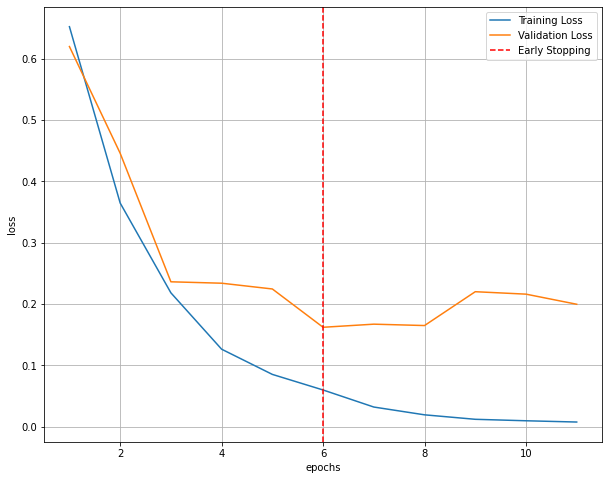

In [13]:
# Visualizing the loss as the network trained


import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))

plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')

#plt.ylim(1.8, 2.2)

plt.xlabel('epochs')
plt.ylabel('loss')

# find position of lowest validation loss
minposs = avg_valid_losses.index(min(avg_valid_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping')

plt.grid(True)
plt.legend()

plt.show()

In [0]:
# define evaluation metrics (acc, precision, recall, and f1-score)
from sklearn.metrics import precision_recall_fscore_support

class Evaluate():
    def __init__(self, out, labels):
        self.out = out.numpy().flatten()
        self.labels = labels.numpy().flatten()
    def accuracy(self):
        nb_correct = sum(y_t==y_p for y_t, y_p in zip(self.labels, self.out))
        nb_true = len(self.labels)
        score = nb_correct / nb_true
        return score
    def precision_recall_fscore(self, tag_list, average='macro'):
        return precision_recall_fscore_support(self.labels, self.out, 
                                                  average=average,labels=tag_list)[:-1]

In [15]:
# evaluate the model on test set 

all_preds = torch.LongTensor().to(device)
all_labels = torch.LongTensor().to(device)

with torch.no_grad():
    for sent, aux_target, target in test_data_generator:
        sent, target = sent.to(device), target.to(device)
        _, tag_scores = model(sent)
        
        predict = tag_scores.data.max(2, keepdim=True)[1]        
        all_preds = torch.cat([all_preds, predict])
        all_labels = torch.cat([all_labels,target])
    
    all_preds, all_labels = all_preds.cpu(), all_labels.cpu()
    all_preds = all_preds.squeeze(dim=-1)
    print()
    evaluator = Evaluate(all_preds, all_labels)
    print('Overall Results on the Test set:')
    print('Accuracy\t{}'.format(evaluator.accuracy()))
    pr, rc, fm = evaluator.precision_recall_fscore(tag_list=[1,2,3]) # we ignore pad  
    print('Precision\t{}\nRecall\t\t{}\nF1-score\t{}'.format(pr,rc,fm))
    
    print('\n==================\n')
    
    print('# Results ignoring O:\n')
    tag_list = [1,2] # we ignore both pad and O
    pr, rc, fm = evaluator.precision_recall_fscore(tag_list)
    print('Precision\t{}\nRecall\t\t{}\nF1-score\t{}'.format(pr,rc,fm))         


Overall Results on the Test set:
Accuracy	0.11595632658270932
Precision	0.6332383832053213
Recall		0.7997608951755261
F1-score	0.5878407598759661


# Results ignoring O:

Precision	0.8988167621813135
Recall		0.7054185848834451
F1-score	0.7892351302096483
